In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import numbers
import math

class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, sigma, kernel_size=None, dim=2):
        super(GaussianSmoothing, self).__init__()
        
        if kernel_size is None:
            kernel_size = 8*sigma + 1
            if kernel_size % 2 == 0:
                kernel_size += 1
        
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        eps = 0.0001
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / ((std + eps) * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / (std + eps)) ** 2 / 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = nn.functional.conv1d
        elif dim == 2:
            self.conv = nn.functional.conv2d
        elif dim == 3:
            self.conv = nn.functional.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        p = int(self.weight.shape[-1] / 2)
#         input = nn.functional.pad(input, (p, p, p, p), mode='reflect')
        input = nn.functional.pad(input, (p, p))
        return self.conv(input, weight=self.weight, groups=self.groups)


def blurred_mse_loss(input, target, sigma):
    input = input.unsqueeze(0).unsqueeze(0)
    target = target.unsqueeze(0).unsqueeze(0)
    g = GaussianSmoothing(1, sigma, dim=1).to(input.device)
    ginput = g(input)
#     gtarget = g(target)
    gtarget = target
    
    return f.mse_loss(ginput, gtarget)

for shade in torch.arange(0, 1, 0.1):
    target = torch.ones(1000) * shade
    
    for spacing in range(1,100):
        image = torch.zeros(1000)
        for i in range(0,1000):
            image[i] = (i%spacing == 0) * 1 
        print(shade, spacing, blurred_mse_loss(image,target, 2).item())

tensor(0.) 1 0.9973214864730835
tensor(0.) 2 0.24933938682079315
tensor(0.) 3 0.11098048090934753
tensor(0.) 4 0.062337037175893784
tensor(0.) 5 0.040032532066106796
tensor(0.) 6 0.028444578871130943
tensor(0.) 7 0.021992435678839684
tensor(0.) 8 0.018220210447907448
tensor(0.) 9 0.01589334011077881
tensor(0.) 10 0.014107226394116879
tensor(0.) 11 0.012797294184565544
tensor(0.) 12 0.011799052357673645
tensor(0.) 13 0.010810330510139465
tensor(0.) 14 0.01010469626635313
tensor(0.) 15 0.0093994140625
tensor(0.) 16 0.00883522629737854
tensor(0.) 17 0.008271044120192528
tensor(0.) 18 0.007847907952964306
tensor(0.) 19 0.007424771785736084
tensor(0.) 20 0.007001636084169149
tensor(0.) 21 0.006719544529914856
tensor(0.) 22 0.006437455303966999
tensor(0.) 23 0.006155364215373993
tensor(0.) 24 0.005873273126780987
tensor(0.) 25 0.005591182038187981
tensor(0.) 26 0.005450136959552765
tensor(0.) 27 0.005258461926132441
tensor(0.) 28 0.00502700125798583
tensor(0.) 29 0.004885955713689327
tensor(

tensor(0.2000) 52 0.034930385649204254
tensor(0.2000) 53 0.03518933802843094
tensor(0.2000) 54 0.03518933802843094
tensor(0.2000) 55 0.03518933802843094
tensor(0.2000) 56 0.03544829413294792
tensor(0.2000) 57 0.03544829040765762
tensor(0.2000) 58 0.03544829040765762
tensor(0.2000) 59 0.035707246512174606
tensor(0.2000) 60 0.035707246512174606
tensor(0.2000) 61 0.035707246512174606
tensor(0.2000) 62 0.035707276314496994
tensor(0.2000) 63 0.03596620634198189
tensor(0.2000) 64 0.03596620634198189
tensor(0.2000) 65 0.03596620261669159
tensor(0.2000) 66 0.03596620634198189
tensor(0.2000) 67 0.03622515872120857
tensor(0.2000) 68 0.03622515872120857
tensor(0.2000) 69 0.03622515872120857
tensor(0.2000) 70 0.03622515872120857
tensor(0.2000) 71 0.036226242780685425
tensor(0.2000) 72 0.03648411110043526
tensor(0.2000) 73 0.036484114825725555
tensor(0.2000) 74 0.03648411110043526
tensor(0.2000) 75 0.03648411110043526
tensor(0.2000) 76 0.03648411110043526
tensor(0.2000) 77 0.03674306720495224
tenso

tensor(0.5000) 4 0.06278736889362335
tensor(0.5000) 5 0.09044700115919113
tensor(0.5000) 6 0.11188386380672455
tensor(0.5000) 7 0.1293955296278
tensor(0.5000) 8 0.1436205506324768
tensor(0.5000) 9 0.1546938717365265
tensor(0.5000) 10 0.16450749337673187
tensor(0.5000) 11 0.17219758033752441
tensor(0.5000) 12 0.17823782563209534
tensor(0.5000) 13 0.1842106133699417
tensor(0.5000) 14 0.18850769102573395
tensor(0.5000) 15 0.19279968738555908
tensor(0.5000) 16 0.1962355524301529
tensor(0.5000) 17 0.19967132806777954
tensor(0.5000) 18 0.20224818587303162
tensor(0.5000) 19 0.2048250436782837
tensor(0.5000) 20 0.20740191638469696
tensor(0.5000) 21 0.20911982655525208
tensor(0.5000) 22 0.2108377367258072
tensor(0.5000) 23 0.2125556319952011
tensor(0.5000) 24 0.21427354216575623
tensor(0.5000) 25 0.21599143743515015
tensor(0.5000) 26 0.2168503999710083
tensor(0.5000) 27 0.2180590182542801
tensor(0.5000) 28 0.21942727267742157
tensor(0.5000) 29 0.22028622031211853
tensor(0.5000) 30 0.22114519774

tensor(0.7000) 52 0.4653306007385254
tensor(0.7000) 53 0.4665895402431488
tensor(0.7000) 54 0.4665895402431488
tensor(0.7000) 55 0.4665895402431488
tensor(0.7000) 56 0.4678484797477722
tensor(0.7000) 57 0.4678485095500946
tensor(0.7000) 58 0.46784844994544983
tensor(0.7000) 59 0.46910741925239563
tensor(0.7000) 60 0.4691074788570404
tensor(0.7000) 61 0.46910741925239563
tensor(0.7000) 62 0.46910756826400757
tensor(0.7000) 63 0.4703664183616638
tensor(0.7000) 64 0.47036638855934143
tensor(0.7000) 65 0.4703664183616638
tensor(0.7000) 66 0.47036638855934143
tensor(0.7000) 67 0.47162532806396484
tensor(0.7000) 68 0.47162529826164246
tensor(0.7000) 69 0.47162535786628723
tensor(0.7000) 70 0.47162529826164246
tensor(0.7000) 71 0.47162917256355286
tensor(0.7000) 72 0.47288429737091064
tensor(0.7000) 73 0.47288432717323303
tensor(0.7000) 74 0.47288426756858826
tensor(0.7000) 75 0.47288423776626587
tensor(0.7000) 76 0.47288426756858826
tensor(0.7000) 77 0.47414323687553406
tensor(0.7000) 78 0.4

In [15]:
def make_gaussian_kernel(sigma, dim=2, kernel_size=None):
    if kernel_size is None:
        kernel_size = 8*sigma + 1
        if kernel_size % 2 == 0:
            kernel_size += 1
            
    if sigma == 0:
        kernel = torch.zeros([kernel_size]*dim)
        kernel[(int(kernel_size/2),)*dim] = 1
        return kernel

    if isinstance(kernel_size, numbers.Number):
        kernel_size = [kernel_size] * dim
    if isinstance(sigma, numbers.Number):
        sigma = [sigma] * dim

    print(kernel_size)
        
    # The gaussian kernel is the product of the
    # gaussian function of each dimension.
    kernel = 1
    meshgrids = torch.meshgrid(
        [
            torch.arange(size, dtype=torch.float32)
            for size in kernel_size
        ]
    )
    print(meshgrids[0].shape)
    eps = 0.0001
    for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
        mean = (size - 1) / 2
        kernel *= 1 / ((std + eps) * math.sqrt(2 * math.pi)) * \
                  torch.exp(-((mgrid - mean) / std) ** 2 / 2)

    # Make sure sum of values in gaussian kernel equals 1.
    kernel = kernel / torch.sum(kernel)
    return kernel


print(make_gaussian_kernel(1.1, dim=1))


[9.8]
torch.Size([10])
tensor([1.2166e-04, 3.0546e-03, 3.3560e-02, 1.6135e-01, 3.3947e-01, 3.1255e-01,
        1.2592e-01, 2.2201e-02, 1.7128e-03, 5.7827e-05])


In [18]:
k2d = make_gaussian_kernel(10, dim=2, kernel_size=None)
k2d = k2d.view(1, 1, *k2d.size())
k2d = k2d.repeat(1, *[1] * (k2d.dim() - 1))
print(k2d.shape)

k1d = make_gaussian_kernel(10, dim=1, kernel_size=None)
k1d = k1d.unsqueeze(0)
k1d = k1d.view(1, 1, *k1d.size())
k1d = k1d.repeat(1, *[1] * (k1d.dim() - 1))
print(k1d.shape)


[81, 81]
torch.Size([81, 81])
torch.Size([1, 1, 81, 81])
[81]
torch.Size([81])
torch.Size([1, 1, 1, 81])


In [20]:
def conv2d(img, ker):
    return nn.functional.conv2d(img, weight=ker, groups=1, padding=(4,4))

def conv2ds(img, ker):
    img = nn.functional.conv2d(img, weight=ker, groups=1, padding=(0,4))
    img = nn.functional.conv2d(img, weight=ker.transpose(-2,-1), groups=1, padding=(4,0))
    return img


input = torch.rand(1,1,1000,1000)
# %timeit o1 = conv2d(input, k2d)
# %timeit o2 = conv2ds(input, k1d)

# torch.allclose(o1,o2)

In [17]:
input = torch.rand(1,1,1000,1000).cuda()
k2dc = k2d.cuda()
k1dc = k1d.cuda()

%timeit o1 = conv2d(input, k2dc)
%timeit o2 = conv2ds(input, k1dc)

torch.allclose(o1,o2)

NameError: name 'k2d' is not defined

In [ ]:
def compute_sigma(prev_sigma, intervals):
    k = 2**(1/intervals)
    sigma = prev_sigma * math.sqrt(k*k - 1)
    return sigma, prev_sigma*k

compute_sigma(2.82, 1)

In [ ]:
def gauss_pyr_kernels(octaves=4, intervals = 1, init_sigma = 0.5, dim=2):
    prev_sigma = init_sigma
    kernels = []
    
    for j in range(octaves):
        for i in range(intervals):
            k = 2**(1/intervals)
            sigma = prev_sigma * math.sqrt(k*k - 1)
            prev_sigma = prev_sigma*k
            kernels.append(make_gaussian_kernel(sigma, dim=2, kernel_size=None))
            print(prev_sigma)
    return kernels

print(list(a.shape for a in gauss_pyr_kernels()))

print(make_gaussian_kernel(8, dim=2, kernel_size=None).shape)

In [29]:
dim = 2
input[...,0::2,0::2].shape
input[...,0::2,:].shape

torch.Size([1, 1, 250, 1000])

In [43]:
import matplotlib.pyplot as plt
from dsketch.raster.disttrans import line_edt2
from dsketch.raster.raster import exp, nearest_neighbour
from dsketch.raster.composite import softor

def chamfer(paramsA, paramsB, grid, sigma):
    # build EDT image from paramsA line segments
    edts2A = line_edt2(paramsA, grid) #paramsA is [nlines_A, 4]
    edt2A, _ = edts2A.min(dim=0)# take min across all edts to get the total edt
    edtA = torch.sqrt(edt2A) # sqrt distances

    # build rasterised image from paramsB line segments
    edts2B = line_edt2(paramsB, grid)
#     ras2B = exp(edts2B, sigma)
    ras2B = nearest_neighbour(edts2B, 0.5)
    # Render image (compositions work on a batch, so adding extra dim and then removing it)
    img2B = softor(ras2B.unsqueeze(0)).squeeze(0) 

    print(img2B[45:55,45:55])
    fig = plt.figure(figsize=(img2B.shape[0], img2B.shape[1]))
    fig.figimage(img2B)
    plt.show()

    #img2B is ~1 on the lines and ~0 elsewhere, so can be used as a mask to select values from
    #the edt which can then be summed over the pixels
    approx_chamfer = (img2B * edtA).sum(dim=(-1,-2)) 

    return approx_chamfer


r = torch.linspace(0, 100, 100)
c = torch.linspace(0, 100, 100)
grid = torch.meshgrid(r, c)
grid = torch.stack(grid, dim=2)

paramsA=torch.tensor([[10, 10, 90, 90], [90, 10, 10, 90]])
paramsB=torch.tensor([[10, 10, 90, 90], [90, 10, 10, 90]])
print(chamfer(paramsA, paramsB, grid, 0.1))

# paramsA=torch.tensor([[10, 10, 90, 90], [90, 10, 10, 90]])
# paramsB=torch.tensor([[15, 10, 95, 90], [90, 15, 10, 95]])
# print(chamfer(paramsA, paramsB, grid, 0.1))


# paramsA=torch.tensor([[10, 10, 90, 90], [90, 10, 10, 90]])
# paramsB=torch.tensor([[1, 1, 1, 90], [1, 1, 90, 1]])
# print(chamfer(paramsA, paramsB, grid, 0.1))



tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])


<Figure size 7200x7200 with 0 Axes>

tensor(0.0002)


downloading yoga from https://storage.googleapis.com/quickdraw_dataset/full/binary/yoga.bin
download complete
loading yoga drawings
load complete


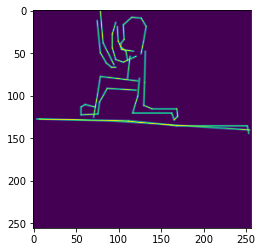

In [33]:
import torch 
from dsketch.raster.disttrans import line_edt2
from dsketch.raster.raster import exp
from dsketch.raster.composite import softor

from quickdraw import QuickDrawDataGroup
from torch.utils.data.dataset import Dataset

import matplotlib.pyplot as plt


#pytorch dataset for a quickdraw data group; uses a 'transform' to convert the
#quickdraw object into something more useful
class QuickDrawDataGroupDataset(Dataset):
    def __init__(self,
                 name,
                 recognized=None,
                 transform=None):

        self.ds = QuickDrawDataGroup(name, recognized=recognized)
        if transform is None:
            self.transform = lambda x: x
        else:
            self.transform = transform

    def __getitem__(self, index):
        return self.transform(self.ds.get_drawing(index))

    def __len__(self):
        return self.ds.drawing_count
    
    
## class to rasterise a quickdraw image
class QuickDrawRasterise:
    def __init__(self, sigma=0.5):
        a = torch.linspace(0, 256, 256)
        grid = torch.meshgrid(a, a)
        self.grid = torch.stack(grid, dim=2)
        self.sigma = 0.5
        
    def __call__(self, qd):
        pts = []
        for stroke in qd.strokes:
            start = stroke[0]
            for i in range(1, len(stroke)):
                end = stroke[i]
                
                pts.append([start[1], start[0], end[1], end[0]]) #swap x,y to i,j
                start = end
                
        params = torch.tensor(pts, dtype=torch.float32)
        edts = line_edt2(params, self.grid)
        ras = exp(edts, self.sigma)
        # Render image (compositions work on a batch, so adding extra dim and then removing it)
        img = softor(ras.unsqueeze(0)).squeeze(0) 
        return img
    
    
ras = QuickDrawRasterise()
ds = QuickDrawDataGroupDataset("yoga", transform=ras)

plt.imshow(ds[1])

In [2]:
import torch
r = torch.linspace(0, 200-1, 200)
c = torch.linspace(0, 100-1, 100)
grid = torch.meshgrid(r, c)
grid = torch.stack(grid, dim=len(grid))

In [13]:
a = *(0,)*2,1
grid[(0,)*2]-grid[(1,)*2]

tensor([-1., -1.])

In [10]:
a

(0, 0, 1)

In [14]:
torch.rand(1,100,100).mean()

tensor(0.5029)

In [19]:
grid.shape[0:-1]

torch.Size([200, 100])

In [21]:
torch.rand(10,200,100).view(2,-1,*grid.shape[0:-1]).shape

torch.Size([2, 5, 200, 100])